***
<div style="text-align:center">
     <h1 align="center">
         <i class="fas fa-calendar-day" aria-hidden="true">  Day 2 of #3D_vision_journey </i>
    </h1>      
</div>

<h3 style='text-align: center;'>
    <img  src="../images/open3d_logo.png" height="50"/>     
</h3>

In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
import sys
import open3d_tutorial as o3dtut

draw_bit = 0

###  Load point cloud 

Load a ply point cloud, print it, and render it
PointCloud with 196133 points.
PointCloud shape: (196133, 3)


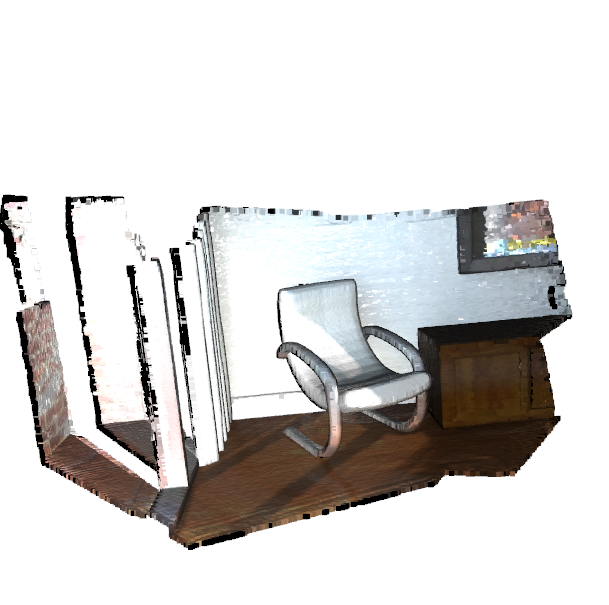

In [16]:

print("Load a ply point cloud, print it, and render it")
# Read a point cloud from file  .xyz  .xyzn  .xyzrgb   .pts   .ply   .pcd
pcd = o3d.io.read_point_cloud("../data/pointcloud/fragment.ply") 

print(pcd)

print(f'PointCloud shape: {np.asarray(pcd.points).shape}')

if not draw_bit:
    o3d.visualization.draw_geometries([pcd])

### Voxel downsampling 


Downsample the point cloud with a voxel of 0.05

Downsampled PointCloud shape: (4718, 3)

Sample Downsampled PointCloud :
 [[1.31028452 2.38109646 2.16783425]
 [1.29074932 2.37168017 2.24696573]]


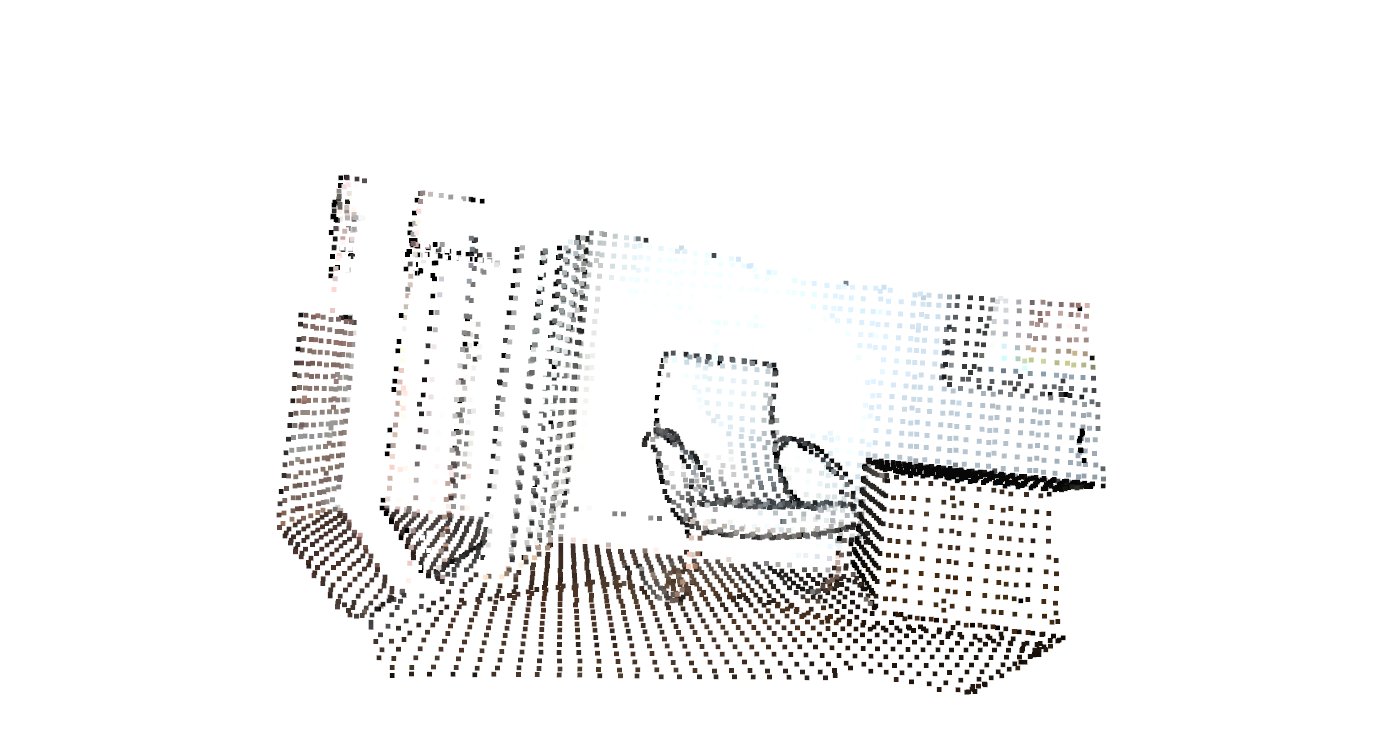

In [5]:
# Voxel Downsampling uses a regular voxel grid 
# to create a uniformly downsampled point cloud
print("Downsample the point cloud with a voxel of 0.05")
downpcd = pcd.voxel_down_sample(voxel_size = 0.05)
print(f'\nDownsampled PointCloud shape: {np.asarray(downpcd.points).shape}')
print(f'\nSample Downsampled PointCloud :\n {np.asarray(downpcd.points)[:2]}')
# draw geometries
if draw_bit:
    o3d.visualization.draw_geometries([downpcd])

###  Vertex  normal estimation 
- If you want to grasp better the geometry washed up by the colour, you can compute normals.
- This will make sure you get a much nicer rendering, as below


Recompute the normal of the downsampled point cloud

Print a normal vector of the 0th point
[-0.48052509  0.51436697 -0.71029731]

Sample Downsampled PointCloud :
 [[0.65234375 0.84686458 2.37890625]
 [0.65234375 0.83984375 2.38430572]]


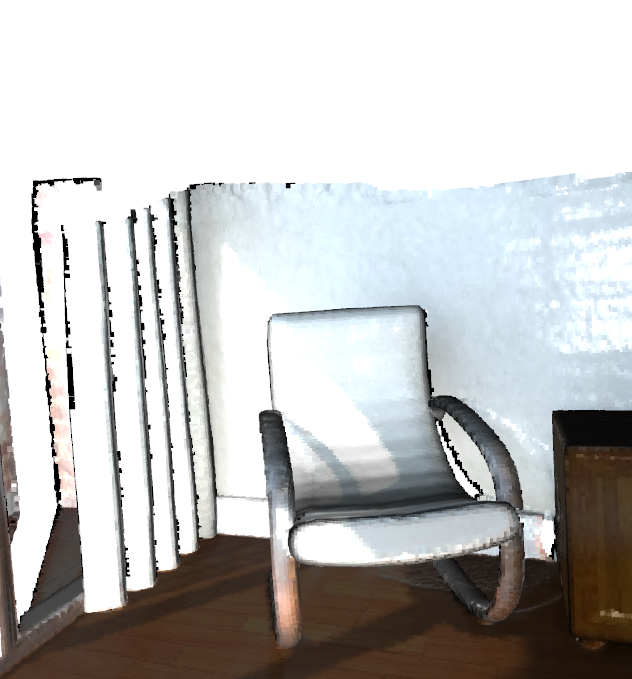

In [18]:
# Compute normal for every point parameter[radius: searching radius, max_nn: maximum nearest neighbor]
print("\nRecompute the normal of the downsampled point cloud")
pcd.estimate_normals(search_param = o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30), fast_normal_computation=True) 
# 10cm of search radius, and only considers up to 30 neighbors to save computation time
print("\nPrint a normal vector of the 0th point")
print(pcd.normals[0])
print(f'\nSample Downsampled PointCloud :\n {np.asarray(pcd.points)[:2]}')

if not draw_bit:
    o3d.visualization.draw_geometries([pcd])

###  Crop point cloud 


Load a polygon volume and use it to crop the original point cloud


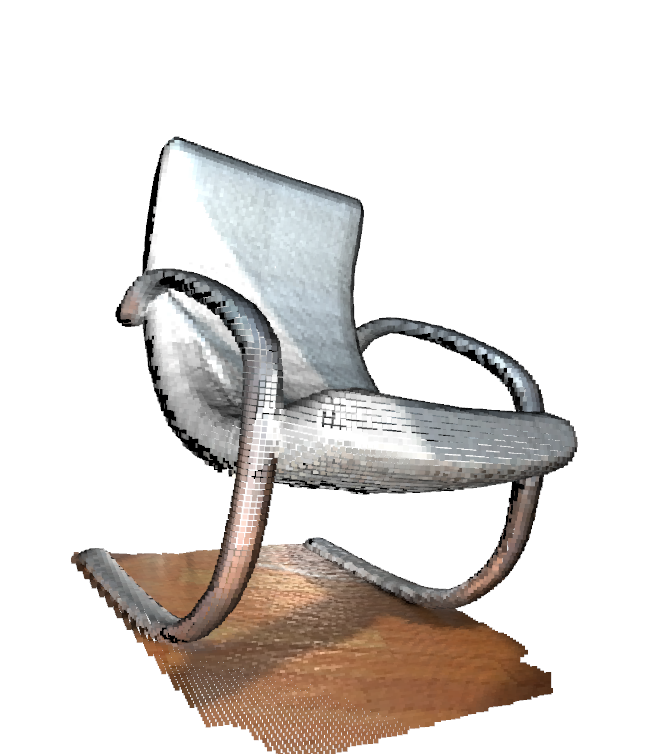

In [7]:
print("Load a polygon volume and use it to crop the original point cloud")
# reads a json file that specifies polygon selection area
vol = o3d.visualization.read_selection_polygon_volume("../data/crop/cropped.json")
# filters out points. Only the chair remains.
chair = vol.crop_point_cloud(pcd)
if draw_bit:
    o3d.visualization.draw_geometries([chair])

***
<div style="text-align:center">
     <h1 align="center">
         <i class="fas fa-calendar-day" aria-hidden="true">  Day 3 of #3D_vision_journey </i>
    </h1>      
</div>

<h3 style='text-align: center;'>
    <img  src="../images/open3d_logo.png" height="50"/>     
</h3>

### Painting point cloud 

Paint chair


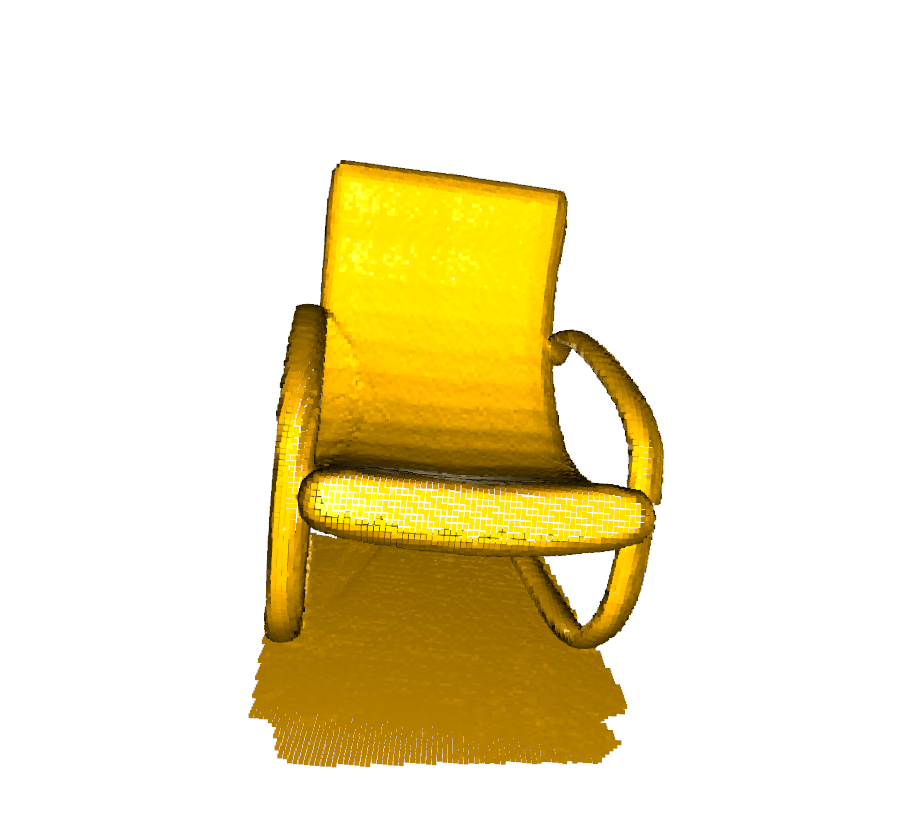

In [8]:
print("Paint chair")
chair.paint_uniform_color([1,0.706,0]) # Paint yellow
if draw_bit:
    o3d.visualization.draw_geometries([chair])

###  Point cloud distance 
* Compute the distance from the source point cloud [pcd] to a target point cloud [chair]

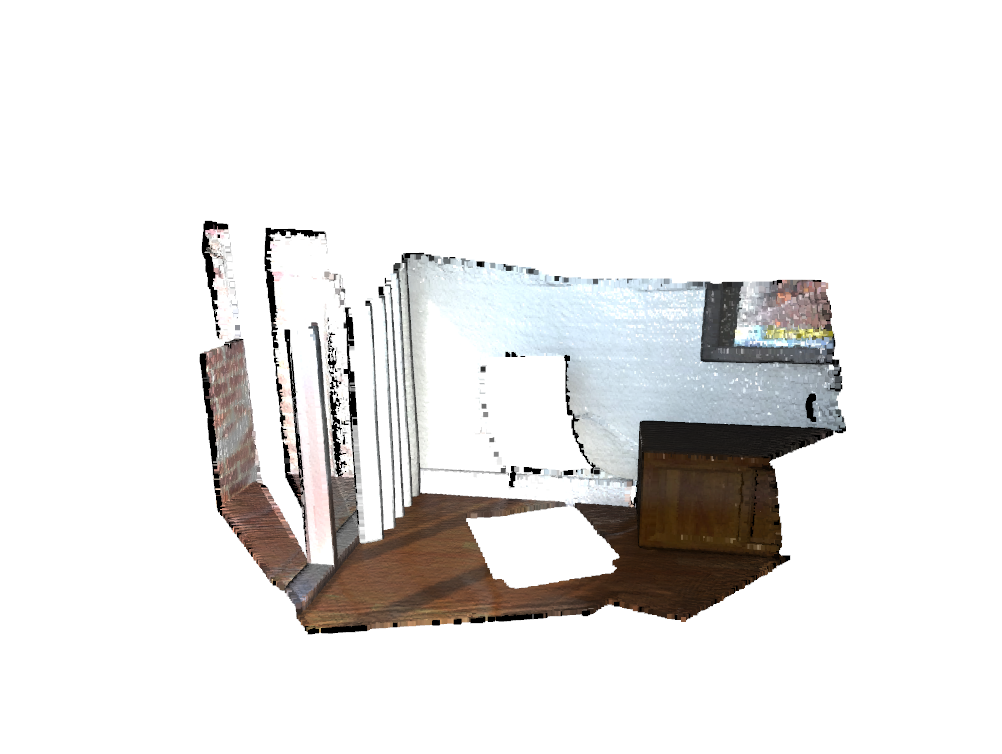

In [9]:
dists = pcd.compute_point_cloud_distance(chair)
dists = np.asarray(dists)
ind = np.where(dists > 0.01)[0] # Find point belong to the [chair] point cloud
pcd_without_chair = pcd.select_by_index(ind) # Remove the chair points
if draw_bit:
    o3d.visualization.draw_geometries([pcd_without_chair])

## Bounding volumes 

In [10]:

boundingAligned = chair.get_axis_aligned_bounding_box()
boundingAligned.color = (1, 0, 0)
boundingOriented = chair.get_oriented_bounding_box()
boundingOriented.color = (0, 1, 0)
boundingAligned, boundingOriented

(AxisAlignedBoundingBox: min: (2.05859, 1.54304, 0.878906), max: (2.76172, 2.41559, 1.68359),
 OrientedBoundingBox: center: (2.38392, 2.11197, 1.39422), extent: 1.16774, 0.725667, 0.866388))

### Convex hull 


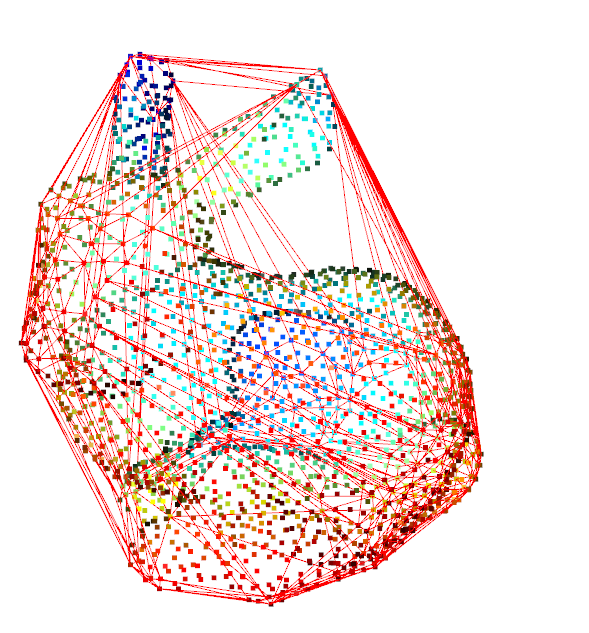

In [3]:
rabit = o3dtut.get_bunny_mesh().sample_points_poisson_disk(number_of_points=2000)
hull, _ = rabit.compute_convex_hull()
hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
hull_ls.paint_uniform_color([1,0,0])
if not draw_bit:
    o3d.visualization.draw_geometries([rabit, hull_ls])

***
<div style="text-align:center">
     <h1 align="center">
         <i class="fas fa-calendar-day" aria-hidden="true">  Day 4 of #3D_vision_journey </i>
    </h1>      
</div>

<h3 style='text-align: center;'>
    <img  src="../images/open3d_logo.png" height="50"/>     
</h3>

### DBSCAN Clustering 
* Group local point cloud clusters together

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 10
point cloud has 10 clusters


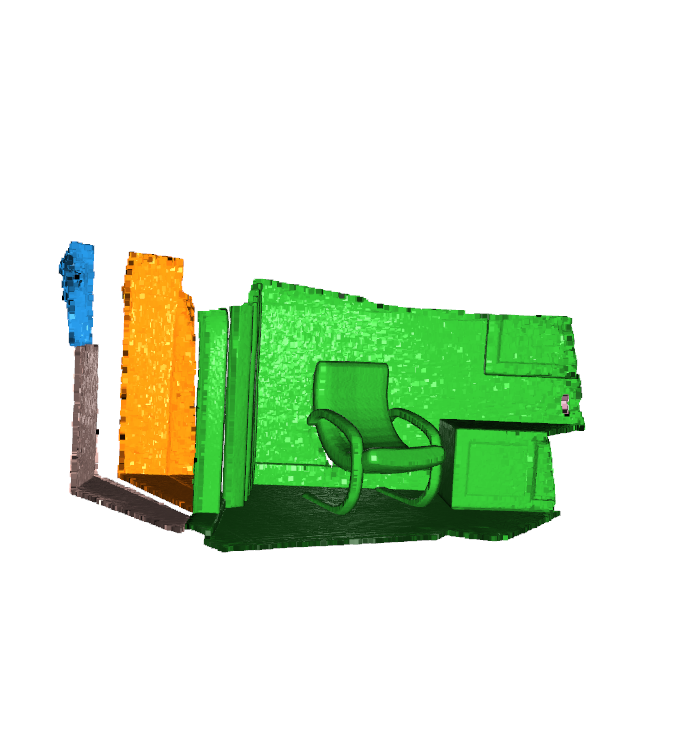

In [4]:

with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array( pcd.cluster_dbscan(eps=0.02, min_points=10, print_progress=True) )
max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
if not draw_bit:
    o3d.visualization.draw_geometries([pcd])

### Plane segmentation 
* Find the plane with the largest support in the point cloud

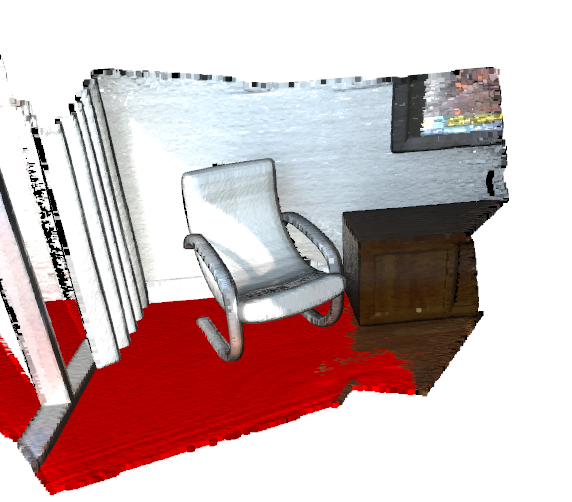

In [5]:
pcd = o3d.io.read_point_cloud("../data/pointcloud/fragment.ply")

# [distance_threshold: defines the maximum distance a point can have to an estimated plane to be considered an inlier]
# [ransac_n: defines the number of points that are randomly sampled to estimate a plane]
# [num_iteration: defines how often a random plane is sampled and verified]
plane_model, inliers = pcd.segment_plane(distance_threshold=0.01,
                                         ransac_n=3,
                                         num_iterations=1000)
[a, b, c, d] = plane_model
inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)

# visualize the point cloud
if not draw_bit:
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                  zoom=0.5,
                                  front=[0.4257, -0.2125, -0.8795],
                                  lookat=[2.6172, 2.0475, 1.532],
                                  up=[-0.0694, -0.9768, 0.2024],
                                  point_show_normal=False)

### Hidden point removal 


Convert mesh to a point cloud and estimate dimensions


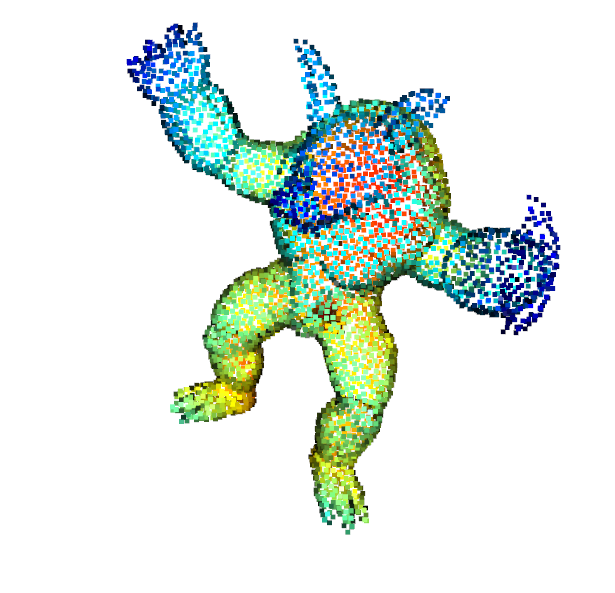

Define parameters used for hidden_point_removal
Get all points that are visible from given view point
Visualize result


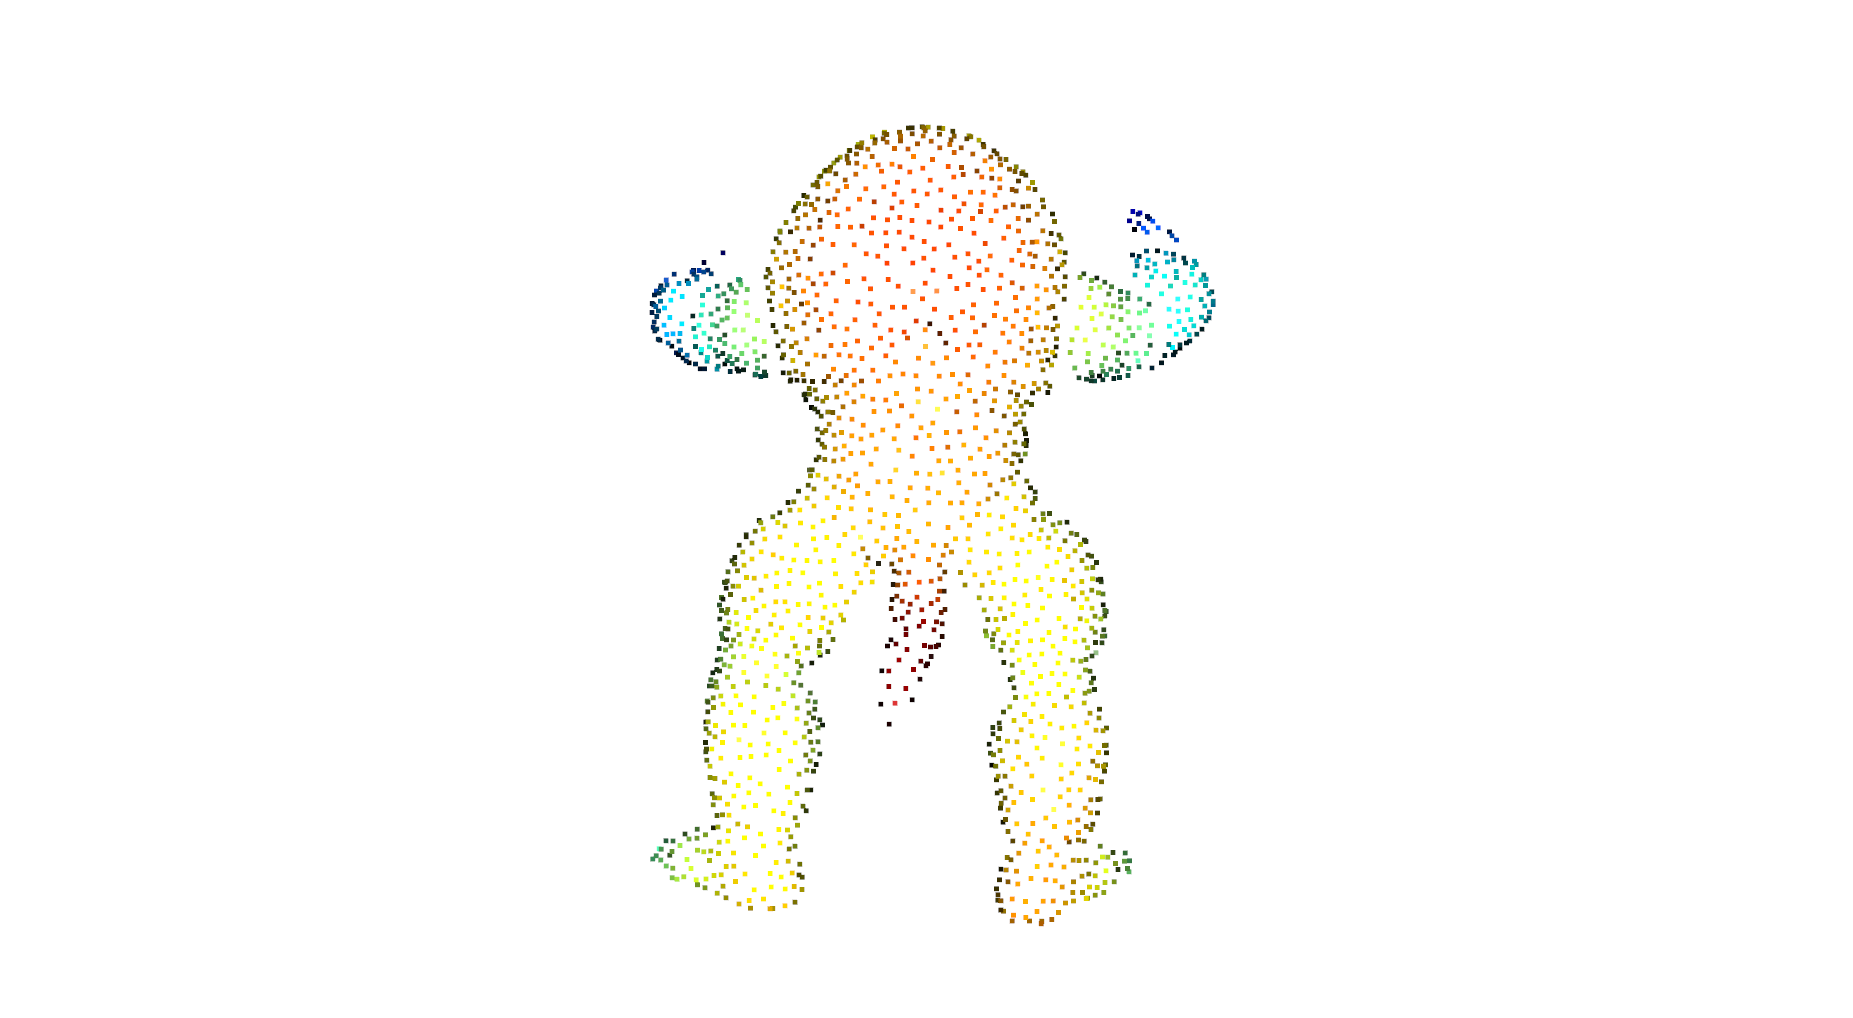

In [20]:
print("Convert mesh to a point cloud and estimate dimensions")
pcd = o3dtut.get_armadillo_mesh().sample_points_poisson_disk(5000)
diameter = np.linalg.norm(
    np.asarray(pcd.get_max_bound()) - np.asarray(pcd.get_min_bound()))
if not draw_bit:
    o3d.visualization.draw_geometries([pcd])

print("Define parameters used for hidden_point_removal")
camera = [0, 0, diameter]
radius = diameter * 100

print("Get all points that are visible from given view point")
_, pt_map = pcd.hidden_point_removal(camera, radius)

print("Visualize result")
pcd = pcd.select_by_index(pt_map)
if not draw_bit:
    o3d.visualization.draw_geometries([pcd])

array([126.19475591, 143.86572182, 100.80932963])